In [10]:
from pathlib import Path
import pandas as pd
import msgpack
import zipfile

In [11]:
DIR = Path("io/2021-03-09")
n = 30
n_responses = n * 30
EMBEDDINGS = DIR / "embeddings.zip"

In [12]:
def _get_history_config(f):
    if isinstance(f, bytes):
        data = msgpack.loads(f)
    else:
        with open(f, "rb") as _f:
            data = msgpack.load(_f)
    return data["meta"], data["history"]

raw = []
with zipfile.ZipFile(EMBEDDINGS) as zf:
    for fname in zf.filelist:
        if ".msgpack" not in fname.filename:
            continue
        with zf.open(fname) as f:
            raw.append(_get_history_config(f.read()))
            
files = DIR.glob(f"*.msgpack")
files = list(files)
print("Number of files:", len(files))
# raw = [_get_history_config(f) for f in files]
print("Read files: ", len(raw))

dfs = []
n_ans = {meta["n_responses"] for meta, _ in raw}
print(n_ans)
print(len(raw))
print({meta["n_responses"] for meta, _ in raw})

mrare = [(meta, hist) for meta, hist in raw if meta["n_responses"] == n_responses]

for meta, hist in mrare:
    alg = meta["alg"]
    df = pd.DataFrame(hist)
    df["alg"] = alg
    for k, v in meta.items():
        if isinstance(v, (dict, list, tuple)):
            continue
        df[k] = v
    dfs.append(df)
print(f"Trimmed files with n_responses={n_responses}:", len(dfs))
df = pd.concat(dfs)
print(len(df))

Number of files: 0
Read files:  1242
{2400, 3300, 900, 3900, 1800, 300, 2700, 1200, 3600, 2100, 3000, 600, 1500}
1242
{2400, 3300, 900, 3900, 1800, 300, 2700, 1200, 3600, 2100, 3000, 600, 1500}
Trimmed files with n_responses=900: 104
1837784


In [13]:
df.iloc[0]

pf_calls                                                             1
num_answers                                                        900
model_updates                                                        2
num_grad_comps                                                    1024
answers_bytes                                                     6000
score_train                                                   0.581111
loss_train                                                    0.693072
k                                                                    0
elapsed_time                                                0.00715566
train_data                                                         900
n                                                                   30
d                                                                    2
max_epochs                                                      400000
verbose                                                           1000
ident 

In [14]:
df["epochs"] = df["num_grad_comps"] / df["num_answers"]

In [15]:
df.columns

Index(['pf_calls', 'num_answers', 'model_updates', 'num_grad_comps',
       'answers_bytes', 'score_train', 'loss_train', 'k', 'elapsed_time',
       'train_data', 'n', 'd', 'max_epochs', 'verbose', 'ident', '_epochs',
       'last_score', 'score_test', 'loss_test', '_elapsed_time', 'alg', 'css',
       'debrief', 'instructions', 'max_queries', 'skip_button', 'est__dwell',
       'est__verbose', 'est__random_state', 'est__max_epochs', 'n_train',
       'n_test', 'n_responses', 'noise_model', 'threads', 'est__module__mu',
       'epochs'],
      dtype='object')

In [16]:
df["sampling"] = df.ident.apply(lambda x: x.split("-")[0])
df["embedding"] = df.ident.apply(lambda x: x.split("-")[1])
df["epochs/1e6"] = df["epochs"] / 1e6
df["epochs/1e3"] = df["epochs"] / 1e3

(0.8, 0.8489771967132885)

(0.8, 0.8758834859977166)

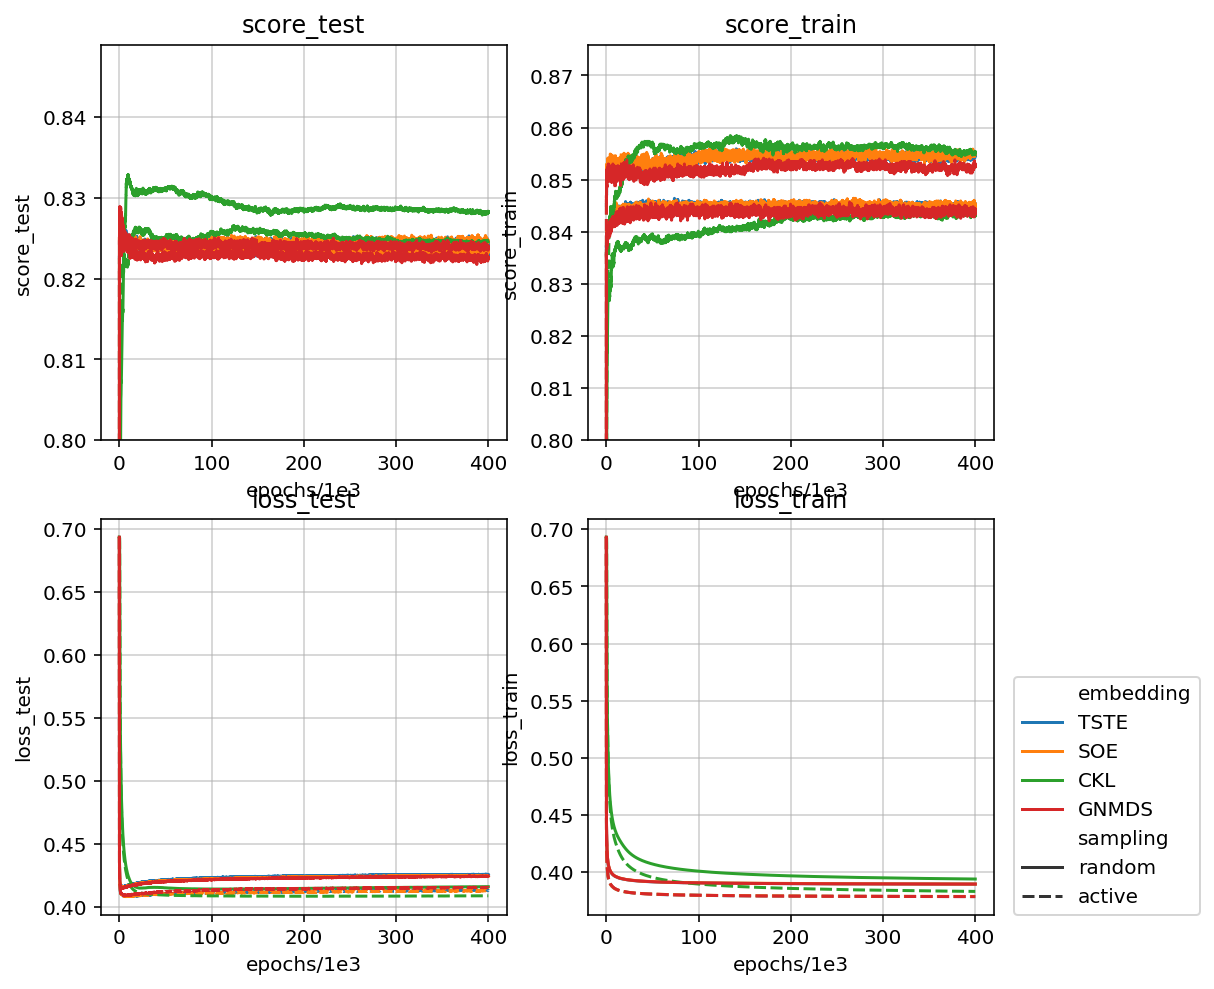

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

w = 4
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2 * w, 2 * w))
# Y = ["accuracy", "nn_diff_p20", "nn_diff_mean", "nn_acc"]
Y = ["score_test", "score_train", "loss_test", "loss_train"]
hue_order = sorted(list(df.alg.unique()))
for k, (y, ax) in enumerate(zip(Y, axs.flatten())):
    _ = sns.lineplot(
        x="epochs/1e3",
        y=y,
        style="sampling",
        style_order=["random", "active"],
        hue="embedding",
#         hue_order=hue_order,
        data=df,#[df.embedding == "CKL"],
        ax=ax,
        ci=None,
    )
    _ = ax.grid(alpha=0.6)
    _ = ax.set_title(y)
    if k != 3:
        ax.legend_.remove()
    else:
        ax.legend(loc=(1.05, 0))
    if "score" in y:
        ax.set_ylim(0.80, None)